### Importing libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from Functions import anoamly_detection
from main import OptimizingPlacement

In [2]:
placement = OptimizingPlacement()
anomaly_detection = anoamly_detection.AnomalyDetection()

In [3]:
file_name = os.getenv('file_name')
sensor_data = os.getenv("folder_name")
zipped_file = os.getenv("ziped_file")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [4]:
combined_data, keys_list = placement.extracting_files(zipped_file, sensor_data)

In [5]:
combined_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-14 02:18:22,15.25,92.8,047D6,047D6 T/RH IP67
1,2024-05-04 21:21:36,13.95,71,047D6,047D6 T/RH IP67
2,2024-05-04 21:26:37,13.65,71.8,047D6,047D6 T/RH IP67
3,2024-05-04 21:31:35,13.4,72.6,047D6,047D6 T/RH IP67
4,2024-05-04 21:36:36,13.4,73.4,047D6,047D6 T/RH IP67


In [6]:
placement.heatmap_video_gen(combined_data, output_dir, video_output)

'Successfully generated the heatmap video.'

In [7]:
combined_data.isnull().sum()

Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

In [8]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [9]:
combined_data['Day'] = pd.DatetimeIndex(combined_data['Time']).day
combined_data['Time_Instance'] = pd.DatetimeIndex(combined_data['Time']).time
combined_data['Year'] = pd.DatetimeIndex(combined_data['Time']).year
combined_data['Month'] = pd.DatetimeIndex(combined_data['Time']).month

In [10]:
combined_data['flag'] = combined_data.isna().any(axis=1).astype(int)

In [11]:
final_dataset = placement.replacing_missing_values(combined_data)

Epoch 1/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 9.1251 - val_loss: 5.5288
Epoch 2/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.2940 - val_loss: 6.4630
Epoch 3/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 5.1630 - val_loss: 5.5613
Epoch 4/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 5.0134 - val_loss: 5.2231
Epoch 5/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.9754 - val_loss: 5.7662
Epoch 6/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.9600 - val_loss: 5.4330
Epoch 7/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.8163 - val_loss: 4.8722
Epoch 8/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.8282 - val_loss: 7.2373
Epoch 9/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.8755 - val_loss: 4.8754
Epoch 10/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.7741 - val_loss: 4.8165
Epoch 11/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 4.6330 - val_loss: 4.8108
Epoch 12/20
8008/8008 ━━━

In [12]:
final_dataset.to_csv('Combined_Data.csv', index=False)

In [12]:
final_dataset[final_dataset['flag'] == 1].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
358,2024-05-05 05:01:20,9.35,83.37,047D6,047D6 T/RH IP67,5,05:01:20,2024,5,1
851,2024-05-20 08:31:34,14.13,83.38,047D6,047D6 T/RH IP67,20,08:31:34,2024,5,1
987,2024-05-07 09:29:43,22.38,57.15,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.45,51.02,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
1038,2024-05-20 15:01:20,30.41,44.46,047D6,047D6 T/RH IP67,20,15:01:20,2024,5,1


In [13]:
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = anomaly_detection.detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

all_anomalies = pd.concat(anomalies_list)

In [14]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [15]:
mlp_temp = anomaly_detection.training_anomaly_model(X_train_scaled, y_train_temp, '', 'temperature')

Epoch 1/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 13.3700 - val_loss: 4.4583e-04
Epoch 2/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 3/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0015 - val_loss: 7.4129e-04
Epoch 4/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0012 - val_loss: 3.5538e-04
Epoch 5/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0011 - val_loss: 1.1405e-04
Epoch 6/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0019 - val_loss: 1.1128e-04
Epoch 7/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 6.7201e-04 - val_loss: 1.1155e-04
Epoch 8/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 6.9649e-04 - val_loss: 0.0045
Epoch 9/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0015 - val_loss: 1.0329e-04
Epoch 10/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 8.2274e-04 - val_loss: 1.1189e-04
Epoch 11/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 

In [16]:
mlp_humidity = anomaly_detection.training_anomaly_model(X_train_scaled, '', y_train_humidity, 'humidity')

Epoch 1/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 222.4548 - val_loss: 0.0036
Epoch 2/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0118 - val_loss: 9.4870e-04
Epoch 3/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0145 - val_loss: 6.8676e-04
Epoch 4/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0112 - val_loss: 0.0025
Epoch 5/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0114 - val_loss: 0.0029
Epoch 6/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0132 - val_loss: 0.0746
Epoch 7/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0136 - val_loss: 3.3753e-04
Epoch 8/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0100 - val_loss: 2.8881e-04
Epoch 9/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0114 - val_loss: 3.8048e-04
Epoch 10/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0093 - val_loss: 0.1070
Epoch 11/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0138 - val_loss: 0.18

In [17]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [18]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])
final_processed_data = all_anomalies.copy()

# final_anomalies = final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)]

In [20]:
final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag,Temperature_anomaly,Humidity_anomaly
75823,2024-05-20 12:18:36,33.880001,31.299999,0474D,0474D T/RH IP67,20,12:18:36,2024,5,0,1,1
75873,2024-05-20 13:18:34,33.930000,29.320000,0474D,0474D T/RH IP67,20,13:18:34,2024,5,0,1,1
75877,2024-05-20 13:38:33,32.619999,28.459999,0474D,0474D T/RH IP67,20,13:38:33,2024,5,0,1,1
232588,2024-04-30 12:18:06,31.570000,34.000000,04750,04750 T/RH IP67,30,12:18:06,2024,4,0,1,1
232590,2024-04-30 12:28:04,31.620001,34.299999,04750,04750 T/RH IP67,30,12:28:04,2024,4,0,1,1


In [21]:
lastday = final_processed_data['Time'].max().date()
last_day_records = final_processed_data[final_processed_data['Time'].dt.date == lastday]

sensor_sample_data = combined_data[combined_data['Time'].dt.date == lastday]

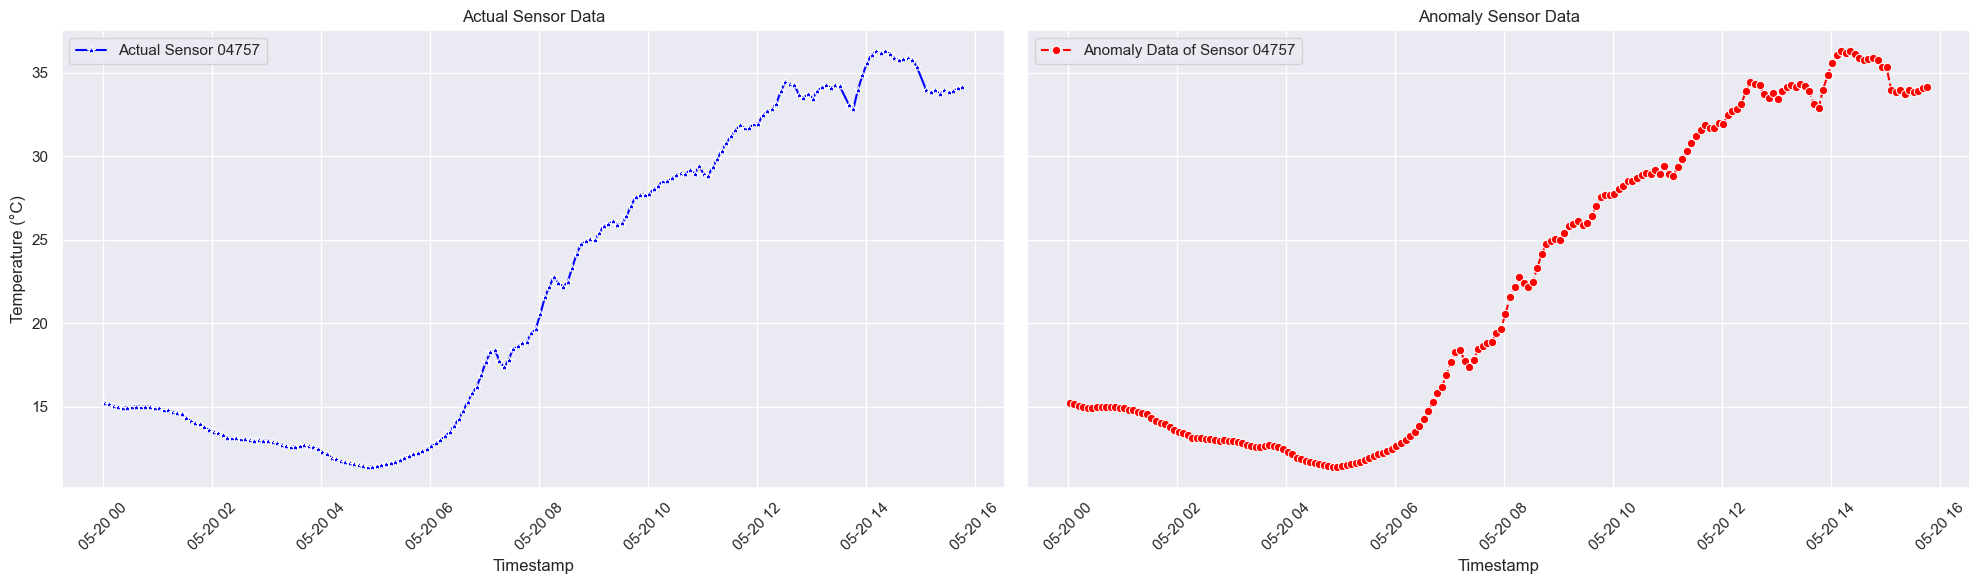

In [22]:
# Set style
sns.set(style="darkgrid")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Original data
sensor_data = sensor_sample_data[sensor_sample_data['Sensor ID'] == '04757']
sns.lineplot(ax=axs[0], x='Time', y='Temperature', data=sensor_data, 
             marker='*', color='blue',
             label='Actual Sensor 04757')

# Filtered data
filtered_sensor_data = last_day_records[last_day_records['Sensor ID'] == '04757']
sns.lineplot(ax=axs[1], x='Time', y='Temperature', data=filtered_sensor_data, 
             marker='o', color='red',
             linestyle='--', label='Anomaly Data of Sensor 04757')

# Titles and labels
axs[0].set_title('Actual Sensor Data')
axs[1].set_title('Anomaly Sensor Data')

for ax in axs:
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Compare/original_and_filtered_plots_side_by_side.png')
plt.show()

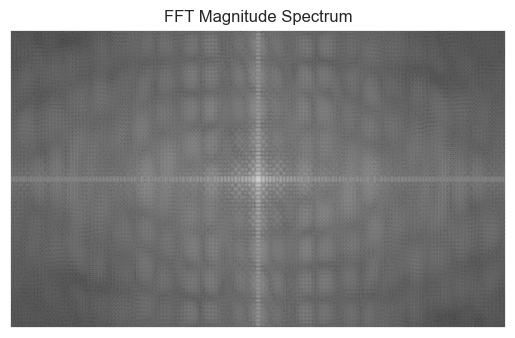

In [40]:
image = cv2.imread('sensor_heatmaps/heatmap_5.png', cv2.IMREAD_GRAYSCALE)

image_float32 = np.float32(image)
image_normalized = image_float32 / 255.0


fft_image = np.fft.fft2(image_normalized)

fft_shifted = np.fft.fftshift(fft_image)

magnitude_spectrum = 20 * np.log(np.abs(fft_shifted))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Magnitude Spectrum'), 
plt.xticks([]), 
plt.yticks([])
plt.show()
